In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sample_submission_V9Inaty.csv
/kaggle/input/train.csv
/kaggle/input/test.csv


# Problem Statement

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

Data
Variable	        Definition

User_ID	----------- User ID

Product_ID --------	Product ID

Gender	----------- Sex of User

Age	--------------- Age in bins

Occupation	------- Occupation (Masked)

City_Category------	Category of the City (A,B,C)

Stay_In_Current_City_Years	------Number of years stay in current city

Marital_Status	--- Marital Status

Product_Category_1	Product Category (Masked)

Product_Category_2	Product may belongs to other category also (Masked)

Product_Category_3	Product may belongs to other category also (Masked)

Purchase	------- Purchase Amount (Target Variable)

**Importing the Dependencies**

In [2]:
#importing libraries required to build the model
import numpy as np 
import pandas as pd
from math import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')        



**Reading the Train and Test Data**

In [3]:
#reading test and train dataset files
train = pd.read_csv("/kaggle/input/train.csv")
test = pd.read_csv("/kaggle/input/test.csv")

#creating dataframe for the required output
submission = pd.DataFrame()
submission['User_ID'] = test['User_ID']
submission['Product_ID'] = test['Product_ID']

**Basic Understanding of the Data**

In [4]:
#Looking at the first 5 rows of the dataset
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
#Trying to understnad the dataset with details of th each columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
#Let us find the null entries in the dataset
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

#We can see that there are 0.17M missing values in Product Category 2 and 0.38M values in Product Category 3

In [7]:
#Finding the null value in terms of percentage
train.isnull().sum()/550068

User_ID                       0.000000
Product_ID                    0.000000
Gender                        0.000000
Age                           0.000000
Occupation                    0.000000
City_Category                 0.000000
Stay_In_Current_City_Years    0.000000
Marital_Status                0.000000
Product_Category_1            0.000000
Product_Category_2            0.315666
Product_Category_3            0.696727
Purchase                      0.000000
dtype: float64

#We can see that 31% and 69% of the data are missing in Product_Category2 & Product_Category_3

In [8]:
#This give the corelation between the numerical category with the target feature
train.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023971,0.020443,0.003825,0.001529,0.003419,0.004716
Occupation,-0.023971,1.000000,0.024280,-0.007618,-0.000384,0.013263,0.020833
Marital_Status,0.020443,0.024280,1.000000,0.019888,0.015138,0.019473,-0.000463
Product_Category_1,0.003825,-0.007618,0.019888,1.000000,0.540583,0.229678,-0.343703
Product_Category_2,0.001529,-0.000384,0.015138,0.540583,1.000000,0.543649,-0.209918
Product_Category_3,0.003419,0.013263,0.019473,0.229678,0.543649,1.000000,-0.022006
Purchase,0.004716,0.020833,-0.000463,-0.343703,-0.209918,-0.022006,1.000000


In [9]:
#Finding the datatype of each features
train.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [10]:
#Let's look at the shape of dataset
print("The Shape of Train dataset is:", train.shape)
print("The Shape of Test dataset is:", test.shape)

The Shape of Train dataset is: (550068, 12)
The Shape of Test dataset is: (233599, 11)


****Univariate Analysis****

# Independent Variable(Categorical)

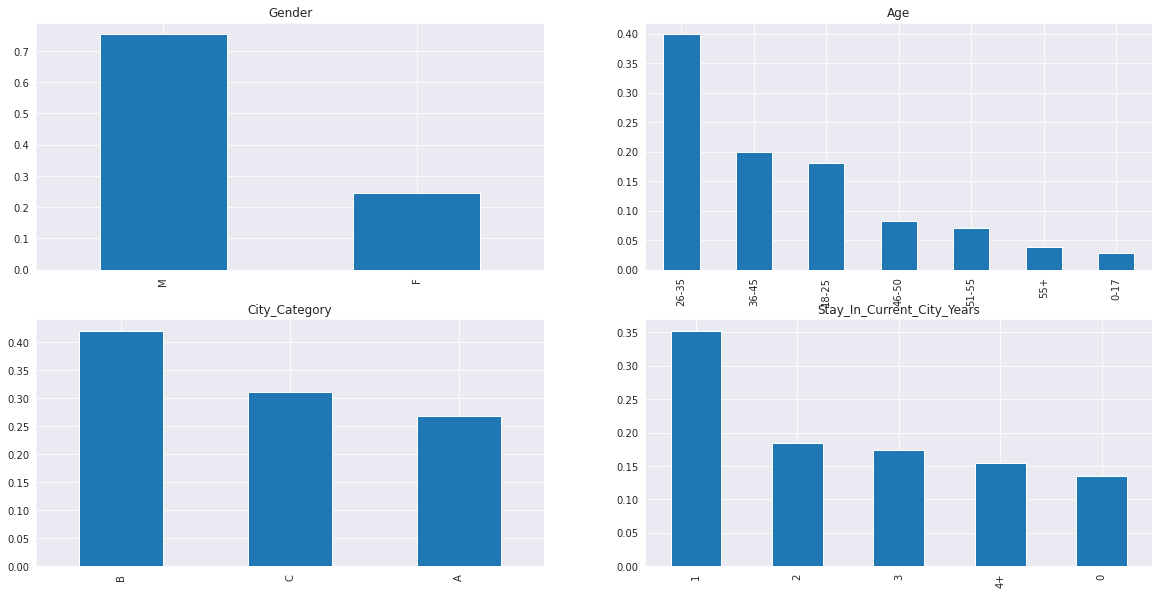

In [11]:
plt.figure(1) 

plt.subplot(221) 
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Gender') 

plt.subplot(222) 
train['Age'].value_counts(normalize=True).plot.bar(title= 'Age') 

plt.subplot(223) 
train['City_Category'].value_counts(normalize=True).plot.bar(title= 'City_Category')

plt.subplot(224) 
train['Stay_In_Current_City_Years'].value_counts(normalize=True).plot.bar(title= 'Stay_In_Current_City_Years')

plt.show()

Key things from the Obesrvation are:
75% of the data is related to Men
40% of the data belongs to age of 26-35 (youngster)
35% people staying the year belong to No of stay years=1

# Independent Variable (Numerical)

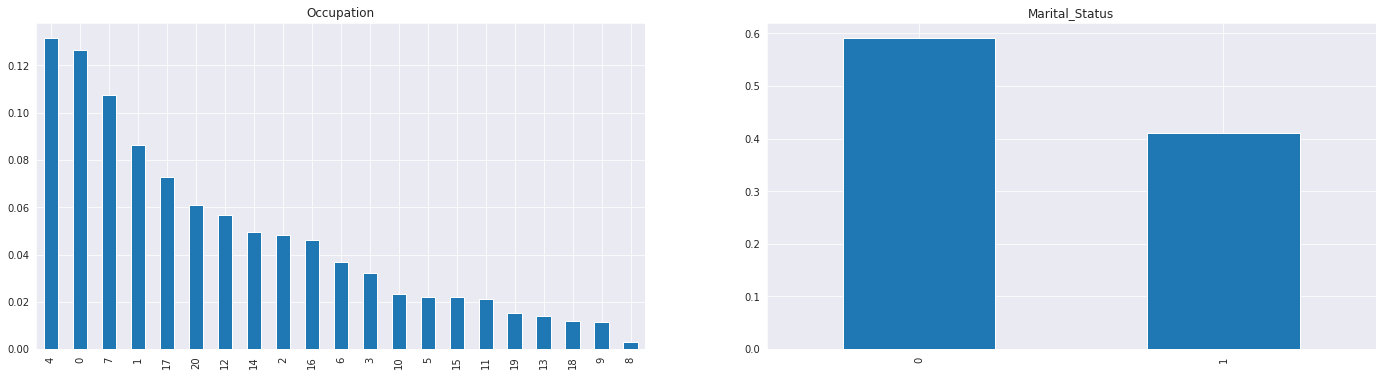

In [12]:
plt.figure(1) 
plt.subplot(121) 
train['Occupation'].value_counts(normalize=True).plot.bar(figsize=(24,6), title= 'Occupation') 

plt.subplot(122) 
train['Marital_Status'].value_counts(normalize=True).plot.bar(title= 'Marital_Status') 

Studying the distribution of the Purchase Amount

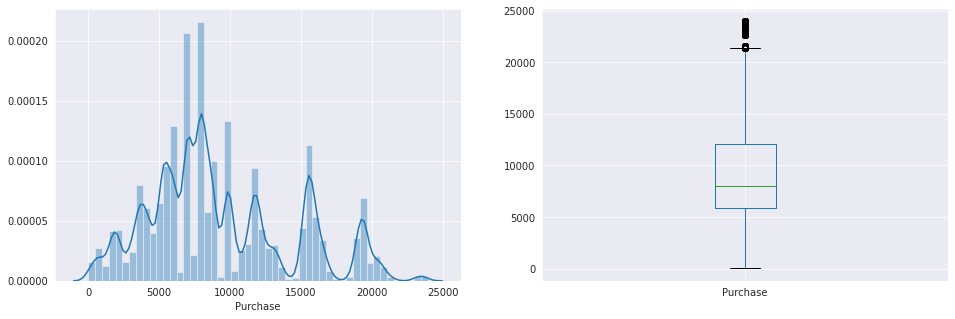

In [13]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(train['Purchase']); 

plt.subplot(122) 
train['Purchase'].plot.box(figsize=(16,5)) 
plt.show()

# Label Encoding

In [14]:
gender_dict = {'F':0, 'M':1}
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
city_dict = {'A':0, 'B':1, 'C':2}
stay_dict = {'0':0, '1':1, '2':2, '3':3, '4+':4}

train["Gender"] = train["Gender"].apply(lambda x: gender_dict[x])
test["Gender"] = test["Gender"].apply(lambda x: gender_dict[x])

train["Age"] = train["Age"].apply(lambda x: age_dict[x])
test["Age"] = test["Age"].apply(lambda x: age_dict[x])

train["City_Category"] = train["City_Category"].apply(lambda x: city_dict[x])
test["City_Category"] = test["City_Category"].apply(lambda x: city_dict[x])

train["Stay_In_Current_City_Years"] = train["Stay_In_Current_City_Years"].apply(lambda x: stay_dict[x])
test["Stay_In_Current_City_Years"] = test["Stay_In_Current_City_Years"].apply(lambda x: stay_dict[x])

# Feature Engineering

Creating a Count Column for each category

In [15]:
train["Age_Count"] = train.groupby(['Age'])['Age'].transform('count')
age_count_dict = train.groupby(['Age']).size().to_dict()
test['Age_Count'] = test['Age'].apply(lambda x:age_count_dict.get(x,0))

train["Occupation_Count"] = train.groupby(['Occupation'])['Occupation'].transform('count')
occupation_count_dict = train.groupby(['Occupation']).size().to_dict()
test['Occupation_Count'] = test['Occupation'].apply(lambda x:occupation_count_dict.get(x,0))

train["Product_Category_1_Count"] = train.groupby(['Product_Category_1'])['Product_Category_1'].transform('count')
pc1_count_dict = train.groupby(['Product_Category_1']).size().to_dict()
test['Product_Category_1_Count'] = test['Product_Category_1'].apply(lambda x:pc1_count_dict.get(x,0))

train["Product_Category_2_Count"] = train.groupby(['Product_Category_2'])['Product_Category_2'].transform('count')
pc2_count_dict = train.groupby(['Product_Category_2']).size().to_dict()
test['Product_Category_2_Count'] = test['Product_Category_2'].apply(lambda x:pc2_count_dict.get(x,0))

train["Product_Category_3_Count"] = train.groupby(['Product_Category_3'])['Product_Category_3'].transform('count')
pc3_count_dict = train.groupby(['Product_Category_3']).size().to_dict()
test['Product_Category_3_Count'] = test['Product_Category_3'].apply(lambda x:pc3_count_dict.get(x,0))

train["User_ID_Count"] = train.groupby(['User_ID'])['User_ID'].transform('count')
userID_count_dict = train.groupby(['User_ID']).size().to_dict()
test['User_ID_Count'] = test['User_ID'].apply(lambda x:userID_count_dict.get(x,0))

train["Product_ID_Count"] = train.groupby(['Product_ID'])['Product_ID'].transform('count')
productID_count_dict = train.groupby(['Product_ID']).size().to_dict()
test['Product_ID_Count'] = test['Product_ID'].apply(lambda x:productID_count_dict.get(x,0))

Creating mean, max, min columns on Purchase feature for each category

In [16]:
train["User_ID_MinPrice"] = train.groupby(['User_ID'])['Purchase'].transform('min')
userID_min_dict = train.groupby(['User_ID'])['Purchase'].min().to_dict()
test['User_ID_MinPrice'] = test['User_ID'].apply(lambda x:userID_min_dict.get(x,0))

train["User_ID_MaxPrice"] = train.groupby(['User_ID'])['Purchase'].transform('max')
userID_max_dict = train.groupby(['User_ID'])['Purchase'].max().to_dict()
test['User_ID_MaxPrice'] = test['User_ID'].apply(lambda x:userID_max_dict.get(x,0))

train["User_ID_MeanPrice"] = train.groupby(['User_ID'])['Purchase'].transform('mean')
userID_mean_dict = train.groupby(['User_ID'])['Purchase'].mean().to_dict()
test['User_ID_MeanPrice'] = test['User_ID'].apply(lambda x:userID_mean_dict.get(x,0))


train["Product_ID_MinPrice"] = train.groupby(['Product_ID'])['Purchase'].transform('min')
productID_min_dict = train.groupby(['Product_ID'])['Purchase'].min().to_dict()
test['Product_ID_MinPrice'] = test['Product_ID'].apply(lambda x:productID_min_dict.get(x,0))

train["Product_ID_MaxPrice"] = train.groupby(['Product_ID'])['Purchase'].transform('max')
productID_max_dict = train.groupby(['Product_ID'])['Purchase'].max().to_dict()
test['Product_ID_MaxPrice'] = test['Product_ID'].apply(lambda x:productID_max_dict.get(x,0))

train["Product_ID_MeanPrice"] = train.groupby(['Product_ID'])['Purchase'].transform('mean')
productID_mean_dict = train.groupby(['Product_ID'])['Purchase'].mean().to_dict()
test['Product_ID_MeanPrice'] = test['Product_ID'].apply(lambda x:productID_mean_dict.get(x,0))

Also, creating 25th and 75th percentile columns on Purchase feature for each category

In [17]:
userID_25p_dict = train.groupby(['User_ID'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['User_ID_25PercPrice'] = train['User_ID'].apply(lambda x:userID_25p_dict.get(x,0))
test['User_ID_25PercPrice'] = test['User_ID'].apply(lambda x:userID_25p_dict.get(x,0))

userID_75p_dict = train.groupby(['User_ID'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['User_ID_75PercPrice'] = train['User_ID'].apply(lambda x:userID_75p_dict.get(x,0))
test['User_ID_75PercPrice'] = test['User_ID'].apply(lambda x:userID_75p_dict.get(x,0))

productID_25p_dict = train.groupby(['Product_ID'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_ID_25PercPrice'] = train['Product_ID'].apply(lambda x:productID_25p_dict.get(x,0))
test['Product_ID_25PercPrice'] = test['Product_ID'].apply(lambda x:productID_25p_dict.get(x,0))

productID_75p_dict = train.groupby(['Product_ID'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_ID_75PercPrice'] = train['Product_ID'].apply(lambda x:productID_75p_dict.get(x,0))
test['Product_ID_75PercPrice'] = test['Product_ID'].apply(lambda x:productID_75p_dict.get(x,0))


train["Product_Cat1_MinPrice"] = train.groupby(['Product_Category_1'])['Purchase'].transform('min')
pc1_min_dict = train.groupby(['Product_Category_1'])['Purchase'].min().to_dict()
test['Product_Cat1_MinPrice'] = test['Product_Category_1'].apply(lambda x:pc1_min_dict.get(x,0))

train["Product_Cat1_MaxPrice"] = train.groupby(['Product_Category_1'])['Purchase'].transform('max')
pc1_max_dict = train.groupby(['Product_Category_1'])['Purchase'].max().to_dict()
test['Product_Cat1_MaxPrice'] = test['Product_Category_1'].apply(lambda x:pc1_max_dict.get(x,0))

train["Product_Cat1_MeanPrice"] = train.groupby(['Product_Category_1'])['Purchase'].transform('mean')
pc1_mean_dict = train.groupby(['Product_Category_1'])['Purchase'].mean().to_dict()
test['Product_Cat1_MeanPrice'] = test['Product_Category_1'].apply(lambda x:pc1_mean_dict.get(x,0))

pc1_25p_dict = train.groupby(['Product_Category_1'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_Cat1_25PercPrice'] = train['Product_Category_1'].apply(lambda x:pc1_25p_dict.get(x,0))
test['Product_Cat1_25PercPrice'] = test['Product_Category_1'].apply(lambda x:pc1_25p_dict.get(x,0))

pc1_75p_dict = train.groupby(['Product_Category_1'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_Cat1_75PercPrice'] = train['Product_Category_1'].apply(lambda x:pc1_75p_dict.get(x,0))
test['Product_Cat1_75PercPrice'] = test['Product_Category_1'].apply(lambda x:pc1_75p_dict.get(x,0))


train["Product_Cat2_MinPrice"] = train.groupby(['Product_Category_2'])['Purchase'].transform('min')
pc2_min_dict = train.groupby(['Product_Category_2'])['Purchase'].min().to_dict()
test['Product_Cat2_MinPrice'] = test['Product_Category_2'].apply(lambda x:pc2_min_dict.get(x,0))

train["Product_Cat2_MaxPrice"] = train.groupby(['Product_Category_2'])['Purchase'].transform('max')
pc2_max_dict = train.groupby(['Product_Category_2'])['Purchase'].max().to_dict()
test['Product_Cat2_MaxPrice'] = test['Product_Category_2'].apply(lambda x:pc2_max_dict.get(x,0))

train["Product_Cat2_MeanPrice"] = train.groupby(['Product_Category_2'])['Purchase'].transform('mean')
pc2_mean_dict = train.groupby(['Product_Category_2'])['Purchase'].mean().to_dict()
test['Product_Cat2_MeanPrice'] = test['Product_Category_2'].apply(lambda x:pc2_mean_dict.get(x,0))

pc2_25p_dict = train.groupby(['Product_Category_2'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_Cat2_25PercPrice'] = train['Product_Category_2'].apply(lambda x:pc2_25p_dict.get(x,0))
test['Product_Cat2_25PercPrice'] = test['Product_Category_2'].apply(lambda x:pc2_25p_dict.get(x,0))

pc2_75p_dict = train.groupby(['Product_Category_2'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_Cat2_75PercPrice'] = train['Product_Category_2'].apply(lambda x:pc2_75p_dict.get(x,0))
test['Product_Cat2_75PercPrice'] = test['Product_Category_2'].apply(lambda x:pc2_75p_dict.get(x,0))

train["Product_Cat3_MinPrice"] = train.groupby(['Product_Category_3'])['Purchase'].transform('min')
pc3_min_dict = train.groupby(['Product_Category_3'])['Purchase'].min().to_dict()
test['Product_Cat3_MinPrice'] = test['Product_Category_3'].apply(lambda x:pc3_min_dict.get(x,0))

train["Product_Cat3_MaxPrice"] = train.groupby(['Product_Category_3'])['Purchase'].transform('max')
pc3_max_dict = train.groupby(['Product_Category_3'])['Purchase'].max().to_dict()
test['Product_Cat3_MaxPrice'] = test['Product_Category_3'].apply(lambda x:pc3_max_dict.get(x,0))

train["Product_Cat3_MeanPrice"] = train.groupby(['Product_Category_3'])['Purchase'].transform('mean')
pc3_mean_dict = train.groupby(['Product_Category_3'])['Purchase'].mean().to_dict()
test['Product_Cat3_MeanPrice'] = test['Product_Category_3'].apply(lambda x:pc3_mean_dict.get(x,0))

pc3_25p_dict = train.groupby(['Product_Category_3'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_Cat3_25PercPrice'] = train['Product_Category_3'].apply(lambda x:pc3_25p_dict.get(x,0))
test['Product_Cat3_25PercPrice'] = test['Product_Category_3'].apply(lambda x:pc3_25p_dict.get(x,0))

pc3_75p_dict = train.groupby(['Product_Category_3'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_Cat3_75PercPrice'] = train['Product_Category_3'].apply(lambda x:pc3_75p_dict.get(x,0))
test['Product_Cat3_75PercPrice'] = test['Product_Category_3'].apply(lambda x:pc3_75p_dict.get(x,0))

In [18]:
#seperating the dependant variable 
train_y = train["Purchase"]
train.drop(["Purchase"], axis=1, inplace=True)

#filling missing values in product categories 2 & 3 by by any constant number say -999
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

#label encoding User ID and Product ID
from sklearn.preprocessing import LabelEncoder
cat_columns_list = ["User_ID", "Product_ID"]
for var in cat_columns_list:
    lb = LabelEncoder()
    full_var_data = pd.concat((train[var],test[var]),axis=0).astype('str')
    temp = lb.fit_transform(np.array(full_var_data))
    train[var] = lb.transform(np.array( train[var] ).astype('str'))
    test[var] = lb.transform(np.array( test[var] ).astype('str'))

For All the models,

1)Splitting Train set into train and validation set in 80:20 ratio

2)Hyperparameter have been found by using GridSearchCV

3)Training the model with complete Train set and getting predictions for 'Purchase' feature of Test set in a .csv file

# Decision Tree Regressor 

In [19]:
X_train,X_test,Y_train,Y_test = train_test_split(train,train_y,test_size=0.2,random_state=42)

dtr = DecisionTreeRegressor(max_depth = 10)
dtr.fit(X_train,Y_train)
y_pred = dtr.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2516.577818822451
R2 Score: 0.7479456116261288


In [20]:
train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Age_Count',
       'Occupation_Count', 'Product_Category_1_Count',
       'Product_Category_2_Count', 'Product_Category_3_Count', 'User_ID_Count',
       'Product_ID_Count', 'User_ID_MinPrice', 'User_ID_MaxPrice',
       'User_ID_MeanPrice', 'Product_ID_MinPrice', 'Product_ID_MaxPrice',
       'Product_ID_MeanPrice', 'User_ID_25PercPrice', 'User_ID_75PercPrice',
       'Product_ID_25PercPrice', 'Product_ID_75PercPrice',
       'Product_Cat1_MinPrice', 'Product_Cat1_MaxPrice',
       'Product_Cat1_MeanPrice', 'Product_Cat1_25PercPrice',
       'Product_Cat1_75PercPrice', 'Product_Cat2_MinPrice',
       'Product_Cat2_MaxPrice', 'Product_Cat2_MeanPrice',
       'Product_Cat2_25PercPrice', 'Product_Cat2_75PercPrice',
       'Product_Cat3_MinPrice', 'Product_Cat3_MaxPrice',
       'Pro

**Now let us remove all the features related to Product category 2 & 3 as they were having many missing values in them**

In [21]:
list2 = ['Product_Category_2','Product_Category_3','Product_Category_2_Count','Product_Category_3_Count','Product_Cat2_MinPrice',
       'Product_Cat2_MaxPrice', 'Product_Cat2_MeanPrice',
       'Product_Cat2_25PercPrice', 'Product_Cat2_75PercPrice',
       'Product_Cat3_MinPrice', 'Product_Cat3_MaxPrice',
       'Product_Cat3_MeanPrice', 'Product_Cat3_25PercPrice',
       'Product_Cat3_75PercPrice']

In [22]:
train_new = train.copy()
train_new.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Age_Count',
       'Occupation_Count', 'Product_Category_1_Count',
       'Product_Category_2_Count', 'Product_Category_3_Count', 'User_ID_Count',
       'Product_ID_Count', 'User_ID_MinPrice', 'User_ID_MaxPrice',
       'User_ID_MeanPrice', 'Product_ID_MinPrice', 'Product_ID_MaxPrice',
       'Product_ID_MeanPrice', 'User_ID_25PercPrice', 'User_ID_75PercPrice',
       'Product_ID_25PercPrice', 'Product_ID_75PercPrice',
       'Product_Cat1_MinPrice', 'Product_Cat1_MaxPrice',
       'Product_Cat1_MeanPrice', 'Product_Cat1_25PercPrice',
       'Product_Cat1_75PercPrice', 'Product_Cat2_MinPrice',
       'Product_Cat2_MaxPrice', 'Product_Cat2_MeanPrice',
       'Product_Cat2_25PercPrice', 'Product_Cat2_75PercPrice',
       'Product_Cat3_MinPrice', 'Product_Cat3_MaxPrice',
       'Pro

In [23]:
train_new.drop(list2, axis=1, inplace=True)

In [24]:
train_new.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Age_Count', 'Occupation_Count', 'Product_Category_1_Count',
       'User_ID_Count', 'Product_ID_Count', 'User_ID_MinPrice',
       'User_ID_MaxPrice', 'User_ID_MeanPrice', 'Product_ID_MinPrice',
       'Product_ID_MaxPrice', 'Product_ID_MeanPrice', 'User_ID_25PercPrice',
       'User_ID_75PercPrice', 'Product_ID_25PercPrice',
       'Product_ID_75PercPrice', 'Product_Cat1_MinPrice',
       'Product_Cat1_MaxPrice', 'Product_Cat1_MeanPrice',
       'Product_Cat1_25PercPrice', 'Product_Cat1_75PercPrice'],
      dtype='object')

In [25]:
X_train,X_test,Y_train,Y_test = train_test_split(train_new,train_y,test_size=0.2,random_state=42)

dtr = DecisionTreeRegressor(max_depth = 10)
dtr.fit(X_train,Y_train)
y_pred = dtr.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2516.642625221712
R2 Score: 0.7479326297524663


# Linear Regression

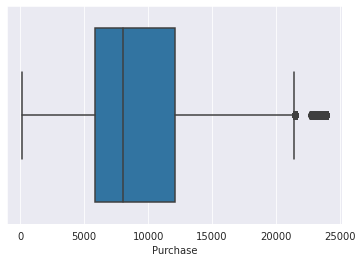

In [26]:
linear_test = test
linear_train = train_new

#dropping User ID and Product ID
linear_train = pd.concat([linear_train,train_y],1)
linear_train = linear_train.drop(['User_ID', 'Product_ID'],1)
linear_test = linear_test.drop(['User_ID', 'Product_ID'],1)

#removing rows corresponding to the unique categorical values only available in train set, not in test set
linear_train = linear_train.drop(linear_train[(linear_train['Product_Category_1']==19) | (linear_train['Product_Category_1']==20)].index)

sns.boxplot(linear_train['Purchase'])

q1 = linear_train['Purchase'].quantile(0.25)
q3 = linear_train['Purchase'].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
linear_train = linear_train[(linear_train['Purchase'] > fence_low) & (linear_train['Purchase'] < fence_high)]

#separating dependant variable
linear_train_y = linear_train["Purchase"]
linear_train.drop(["Purchase"], axis=1, inplace=True)

#changing data type of categorical variable to string so as to one hot encode them using get_dummies
#strlist = ['Gender', 'Age', 'Occupation', 'City_Category',
#       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
#       'Product_Category_2', 'Product_Category_3']
#for s in strlist:
#    linear_train[s] = linear_train[s].astype(str)
#    linear_test[s] = linear_test[s].astype(str)


In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(linear_train,linear_train_y,test_size=0.2,random_state=42)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2549.803311137558
R2 Score: 0.7284418210859331


# Ridge Regression

In [28]:
regressor = Ridge(alpha = 10)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2549.803335700889
R2 Score: 0.7284418158538641


# Lasso Regression

In [29]:
regressor = Lasso(alpha = 0.1)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2549.818856413406
R2 Score: 0.728438509881771


# XGBoost Model

Creating 2 XGBoost Models both with different learning rates and different set of features for both of them

XG Boost model 1 (learning rate = 0.5), and features set = alist + blist (mentioned below)

XG Boost model 2 (learinng rate = 0.3), and features set = alist + clist** (mentioned below)

In [30]:
alist = ['User_ID',
'Product_ID',
'Gender',
'Age',
'Occupation',
'City_Category',
'Stay_In_Current_City_Years',
'Marital_Status',
'Product_Category_1',
'Age_Count',
'Occupation_Count',
'Product_Category_1_Count',
'User_ID_Count',
'Product_ID_Count']
         
blist = ['User_ID_MinPrice',
'User_ID_MaxPrice',
'User_ID_MeanPrice',
'Product_ID_MinPrice',
'Product_ID_MaxPrice',
'Product_ID_MeanPrice']

clist = ['User_ID_25PercPrice',
'User_ID_75PercPrice',
'Product_ID_25PercPrice',
'Product_ID_75PercPrice',
'Product_Cat1_MinPrice',
'Product_Cat1_MaxPrice',
'Product_Cat1_MeanPrice',
'Product_Cat1_25PercPrice',
'Product_Cat1_75PercPrice',
]

In [31]:
#XGB model 1 dataframe
train1 = train_new[alist+blist]
test1 = test[alist+blist]

#XGB model 2 dataframe 
train2 = train_new[alist+clist]
test2 = test[alist+clist]

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(train1,train_y,test_size=0.2,random_state=42)

params = {}
params["eta"] = 0.05
params["min_child_weight"] = 10
params["subsample"] = 0.8
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["seed"] = 0
plst = list(params.items())
num_rounds = 750

In [33]:
xgtrain = xgb.DMatrix(X_train, label=Y_train)
xgtest_1 = xgb.DMatrix(X_test)
model1 = xgb.train(plst, xgtrain, num_rounds)

In [34]:
pred_test_y = model1.predict(xgtest_1)
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(pred_test_y, Y_test))
print("RMSE Score: ",rmse)
r2 = r2_score(Y_test, pred_test_y)

print("R2 Score:", r2)

RMSE Score:  2407.132624827813
R2 Score: 0.7693924231135882


In [35]:
feature_important = model1.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
total = sum(values)
new = [value * 100. / total for value in values]
new = np.round(new,2)

feature_importances = pd.DataFrame()
feature_importances['Features'] = keys
feature_importances['Importance (%)'] = new
feature_importances = feature_importances.sort_values(['Importance (%)'],ascending=False).reset_index(drop=True)
feature_importances
feature_importances.style.set_properties(**{'font-size':'10pt'})

,Features,Importance (%)
0,Product_ID_MeanPrice,47.27
1,Product_ID_MaxPrice,22.66
2,Product_ID_MinPrice,5.68
3,User_ID_MeanPrice,3.6
4,Product_Category_1_Count,2.32
5,Product_ID_Count,1.62
6,Gender,1.61
7,User_ID_MaxPrice,1.56
8,User_ID_Count,1.42
9,Product_Category_1,1.4


Plotting the Feature Importance

Text(0, 0.5, 'Features')

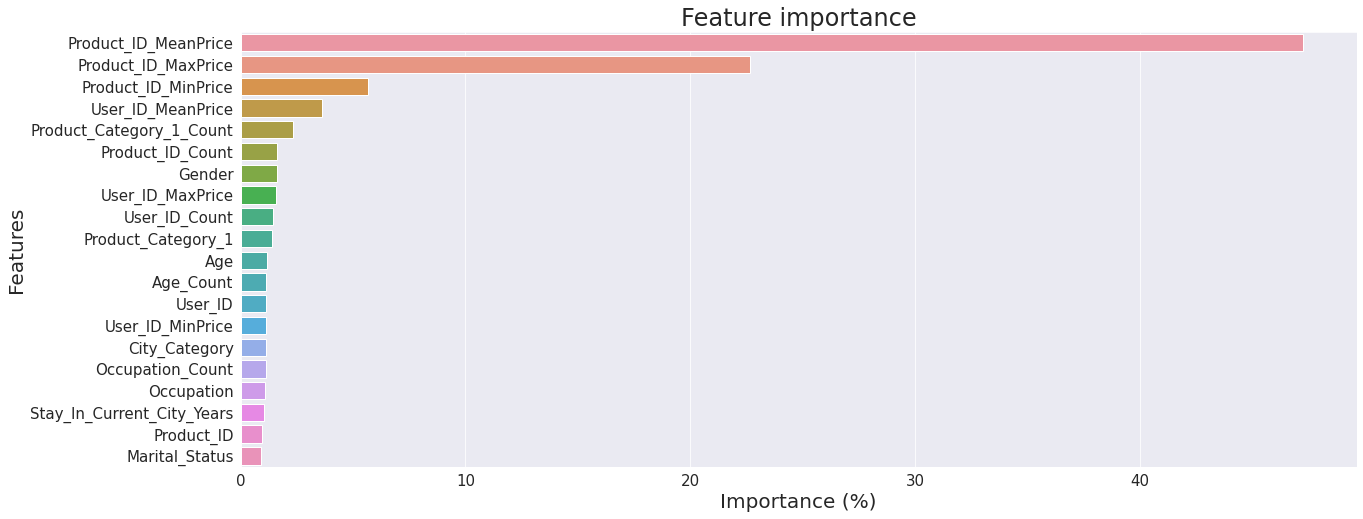

In [36]:
plt.figure(figsize=(20, 8))
sns.barplot(data=feature_importances, x='Importance (%)', y='Features');
plt.title('Feature importance',fontsize=24)
plt.xlabel('Importance (%)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Features',fontsize=20)

In [38]:
#Let's predict on the test set
xgtrain = xgb.DMatrix(train1, label=train_y)
xgtest = xgb.DMatrix(test1)
model1 = xgb.train(plst, xgtrain, num_rounds)

submission_1 = submission.copy()
#prediction1
pred_xgb_m1 = model1.predict(xgtest)
submission_1['Purchase'] = pred_xgb_m1
submission_1.to_csv('xgb_model1.csv',index=False)

In [39]:
X_train,X_test,Y_train,Y_test = train_test_split(train2,train_y,test_size=0.2,random_state=42)

#These parameters are found using GridSearchCV by checking R2 score & RMSE on validation set
params = {}
params["eta"] = 0.03
params["min_child_weight"] = 10
params["subsample"] = 0.8
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["seed"] = 0
plst = list(params.items())
num_rounds = 1100


In [40]:
import xgboost as xgb
xgtrain = xgb.DMatrix(X_train, label=Y_train)
xgtest_2 = xgb.DMatrix(X_test)
model2 = xgb.train(plst, xgtrain, num_rounds)

In [41]:
pred_test_y = model2.predict(xgtest_2)
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(pred_test_y, Y_test))
print("RMSE Score: ",rmse)
r2 = r2_score(Y_test, pred_test_y)

print("R2 Score:", r2)

RMSE Score:  2418.2545987956005
R2 Score: 0.7672564903453252


In [42]:
feature_important = model2.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
total = sum(values)
new = [value * 100. / total for value in values]
new = np.round(new,2)

feature_importances = pd.DataFrame()
feature_importances['Features'] = keys
feature_importances['Importance (%)'] = new
feature_importances = feature_importances.sort_values(['Importance (%)'],ascending=False).reset_index(drop=True)
feature_importances
feature_importances.style.set_properties(**{'font-size':'10pt'})

,Features,Importance (%)
0,Product_ID_75PercPrice,34.81
1,Product_Cat1_MinPrice,18.16
2,Product_Cat1_MaxPrice,12.61
3,Product_ID_25PercPrice,12.25
4,Product_Cat1_MeanPrice,3.8
5,Product_Category_1_Count,3.09
6,User_ID_75PercPrice,1.87
7,User_ID_25PercPrice,1.65
8,Product_Cat1_75PercPrice,1.3
9,Gender,0.9


Text(0, 0.5, 'Features')

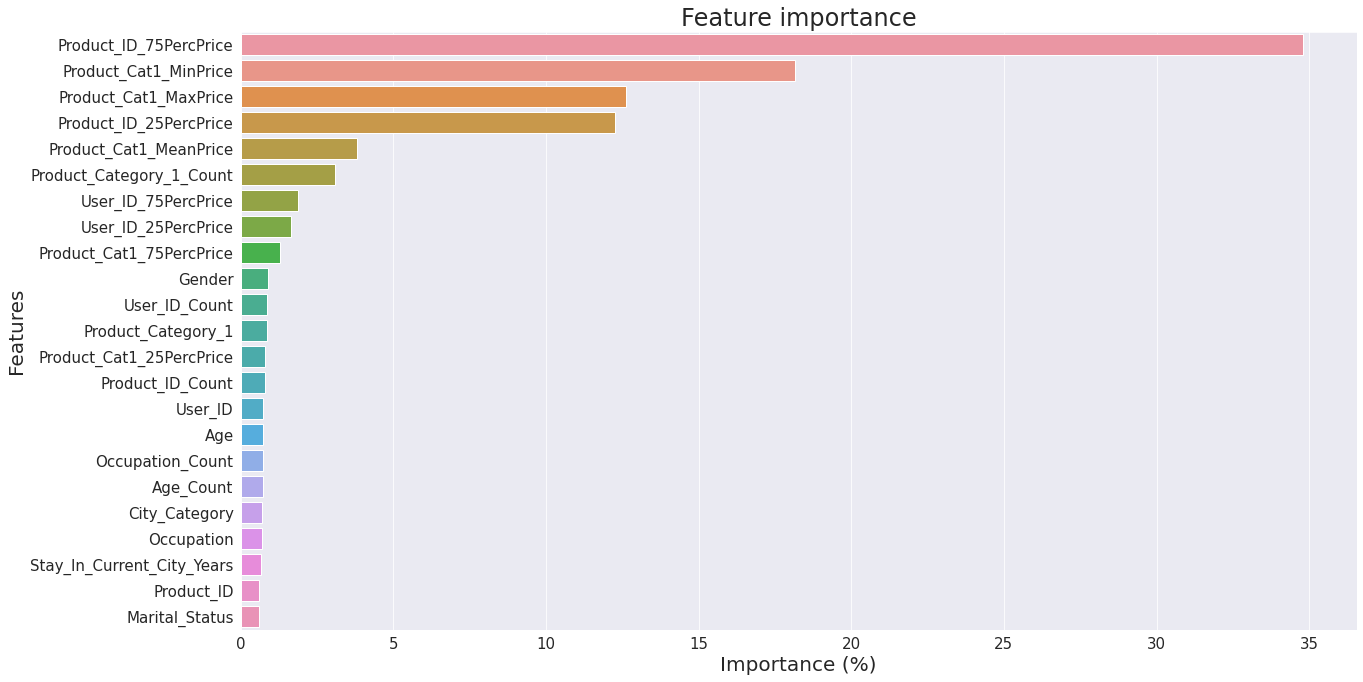

In [43]:
plt.figure(figsize=(20, 11))
sns.barplot(data=feature_importances, x='Importance (%)', y='Features');
plt.title('Feature importance',fontsize=24)
plt.xlabel('Importance (%)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Features',fontsize=20)

In [ ]:
#Let us Predict on test dataset
xgtrain = xgb.DMatrix(train2, label=train_y)
xgtest = xgb.DMatrix(test2)
model2 = xgb.train(plst, xgtrain, num_rounds)

submission_2 = submission.copy()
#prediction2
pred_xgb_m2 = model2.predict(xgtest)
submission_2['Purchase'] = pred_xgb_m2
submission_2.to_csv('xgb_model2.csv',index=False)

In [ ]:
submission_3 = submission.copy()
submission_3['Purchase'] = 0.3*pred_xgb_m1 + 0.7*pred_xgb_m2
submission_3.to_csv('uppin.csv',index=False)